# Notes in Chapter 6
1. The simplest unit in (deep) neural networks is a linear operation (scaling + offset) followed by an activation function.
2. Any module in nn is written to produce outputs for a batch of multiple inputs at the
same time. To accommodate multiple samples, modules expect the zeroth dimension of the input to be the number of samples in the batch.

## 6.2 The PyTorch nn module

In [15]:
import torch

t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).float().unsqueeze(-1)
t_u = torch.tensor(t_u).float().unsqueeze(-1)
t_un = 0.1 * t_u

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
valid_indices = shuffled_indices[-n_val:]

train_t_u = t_un[train_indices]
train_t_c = t_c[train_indices]

valid_t_u = t_un[valid_indices]
valid_t_c = t_c[valid_indices]

In [10]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)
linear_model(valid_t_u.unsqueeze(-1))

tensor([[-0.0345],
        [ 0.1744]], grad_fn=<AddmmBackward>)

In [12]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[-0.0633]], requires_grad=True),
 Parameter containing:
 tensor([0.4841], requires_grad=True))

In [13]:
x = torch.ones(1)
x.shape, linear_model(x)

(torch.Size([1]), tensor([0.4208], grad_fn=<AddBackward0>))

In [14]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.4208],
        [0.4208],
        [0.4208],
        [0.4208],
        [0.4208],
        [0.4208],
        [0.4208],
        [0.4208],
        [0.4208],
        [0.4208]], grad_fn=<AddmmBackward>)

In [17]:
import torch.optim as optim

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

list(linear_model.parameters())

[Parameter containing:
 tensor([[0.3184]], requires_grad=True),
 Parameter containing:
 tensor([-0.5032], requires_grad=True)]

In [18]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1, n_epochs+1):
        train_t_p = model(train_t_u)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad():
            val_t_p = model(val_t_u)
            val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch == 1 or epoch % 100 == 0:
            print('Epoch {}, Train loss {:.4f}, Validation loss {:.4f}'.format(epoch, train_loss, val_loss))

In [21]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

training_loop(
    n_epochs=1000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    train_t_u=train_t_u,
    train_t_c=train_t_c,
    val_t_u=valid_t_u,
    val_t_c=valid_t_c
)

list(linear_model.parameters())

Epoch 1, Train loss 197.7142, Validation loss 246.8220
Epoch 100, Train loss 21.8912, Validation loss 18.7865
Epoch 200, Train loss 16.5119, Validation loss 13.7506
Epoch 300, Train loss 12.6348, Validation loss 10.3105
Epoch 400, Train loss 9.8403, Validation loss 7.9921
Epoch 500, Train loss 7.8262, Validation loss 6.4577
Epoch 600, Train loss 6.3746, Validation loss 5.4679
Epoch 700, Train loss 5.3283, Validation loss 4.8530
Epoch 800, Train loss 4.5742, Validation loss 4.4934
Epoch 900, Train loss 4.0307, Validation loss 4.3053
Epoch 1000, Train loss 3.6389, Validation loss 4.2299


[Parameter containing:
 tensor([[4.8099]], requires_grad=True),
 Parameter containing:
 tensor([-14.5352], requires_grad=True)]

## 6.3 Finally a neural network

In [22]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [23]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [24]:
from collections import OrderedDict

seq_model = nn.Sequential(
    OrderedDict([
        ('hidden_linear', nn.Linear(1, 8)),
        ('hidden_activation', nn.Tanh()),
        ('output_linear', nn.Linear(8, 1))
    ])
)

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [25]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [26]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.0221], requires_grad=True)

In [28]:
seq_model.hidden_linear.bias

Parameter containing:
tensor([-0.6904, -0.4268, -0.0256,  0.2719, -0.7244, -0.9350,  0.1133, -0.4827],
       requires_grad=True)

In [29]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=2000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    train_t_u=train_t_u,
    train_t_c=train_t_c,
    val_t_u=valid_t_u,
    val_t_c=valid_t_c
)

print('output', seq_model(valid_t_u))
print('answer', valid_t_c)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Train loss 177.1393, Validation loss 222.6890
Epoch 100, Train loss 69.6583, Validation loss 85.1600
Epoch 200, Train loss 52.8461, Validation loss 60.8052
Epoch 300, Train loss 38.7526, Validation loss 42.4418
Epoch 400, Train loss 27.2881, Validation loss 27.8843
Epoch 500, Train loss 18.7628, Validation loss 17.9917
Epoch 600, Train loss 13.2317, Validation loss 12.5348
Epoch 700, Train loss 9.8463, Validation loss 9.9658
Epoch 800, Train loss 7.7518, Validation loss 8.8398
Epoch 900, Train loss 6.3831, Validation loss 8.3024
Epoch 1000, Train loss 5.4251, Validation loss 7.9658
Epoch 1100, Train loss 4.7681, Validation loss 6.8388
Epoch 1200, Train loss 8.8099, Validation loss 1.9620
Epoch 1300, Train loss 7.5513, Validation loss 2.4436
Epoch 1400, Train loss 6.6643, Validation loss 2.7370
Epoch 1500, Train loss 5.9582, Validation loss 2.9478
Epoch 1600, Train loss 5.3712, Validation loss 3.1129
Epoch 1700, Train loss 4.8743, Validation loss 3.2484
Epoch 1800, Train loss 4

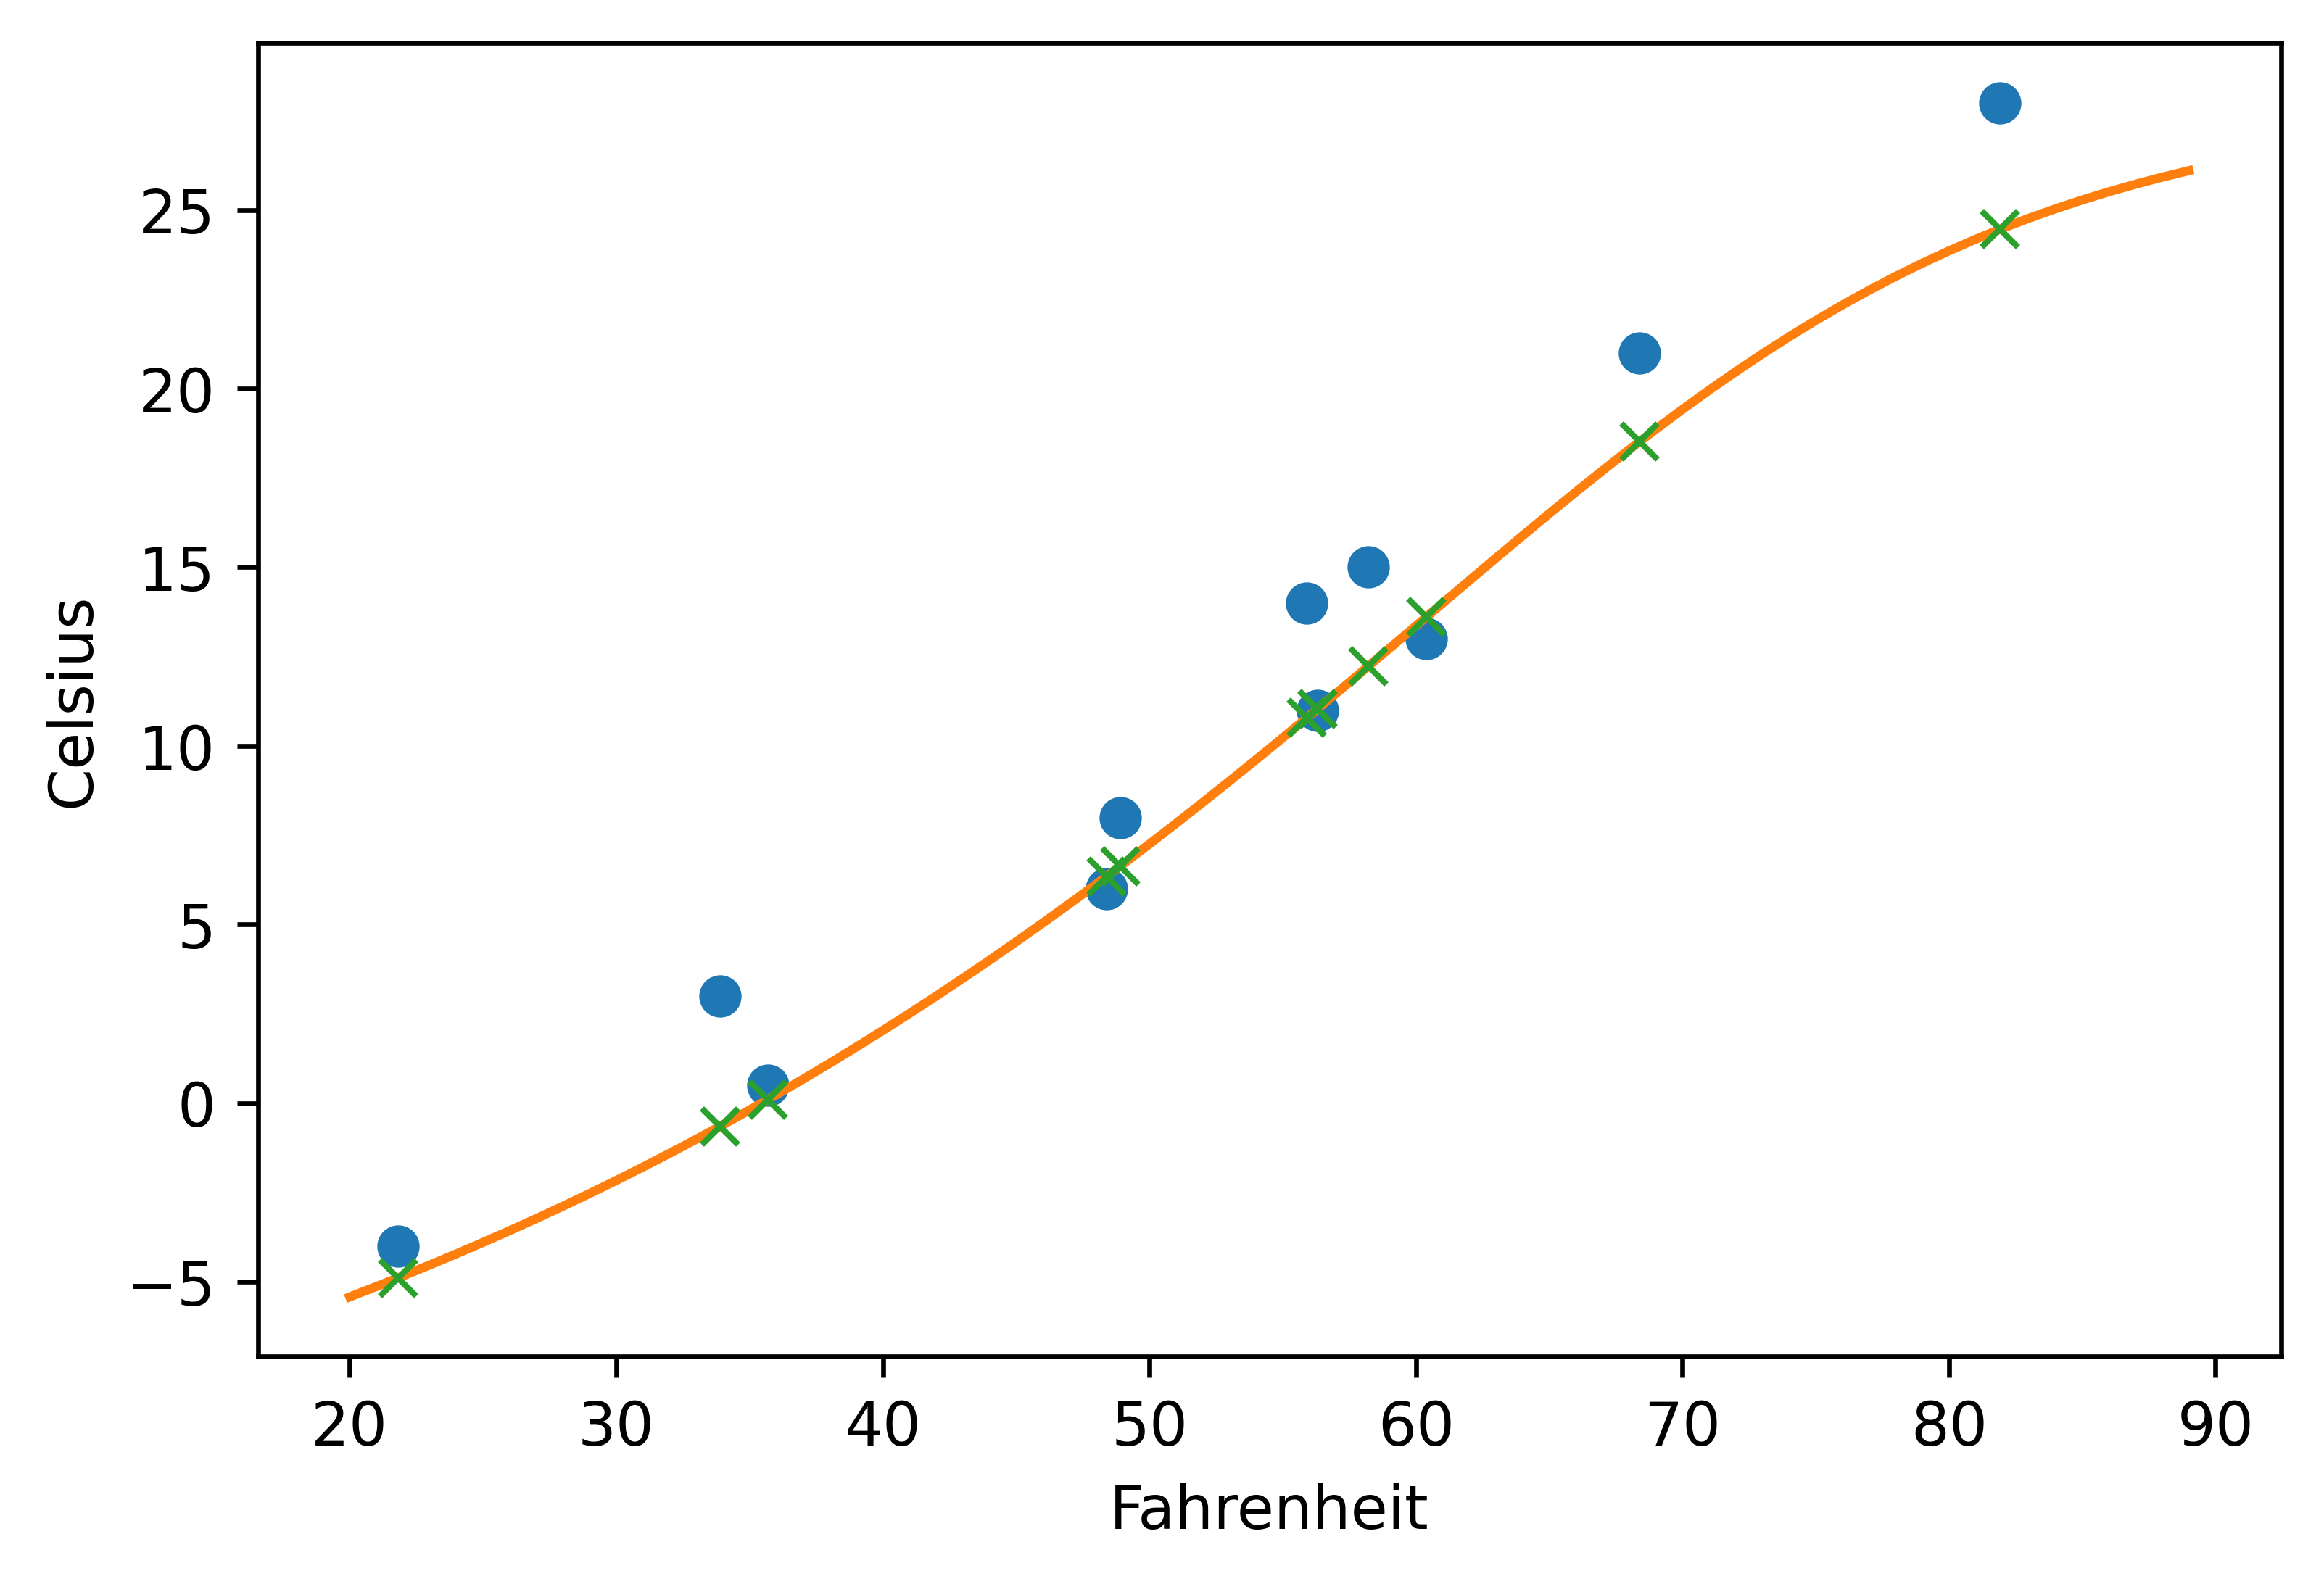

In [33]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(-1)

fig = plt.figure(dpi=600)
plt.xlabel('Fahrenheit')
plt.ylabel('Celsius')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), '-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'x')

## Exercise 2

In [37]:
import numpy as np

wine_path = 'data/ch4/tabular-wine/winequality-white.csv'
wineq_np = np.loadtxt(wine_path, dtype=np.float32, delimiter=';', skiprows=1)
wine_data = torch.from_numpy(wineq_np).float()
input = wine_data[:, :-1]
output = wine_data[:, -1:]

n_samples = wine_data.shape[0]
n_train = int(n_samples * 0.7)
shuffled_indices = torch.randperm(n_samples)

train_input = input[shuffled_indices[:n_train]]
train_output = output[shuffled_indices[:n_train]]

test_input = input[shuffled_indices[n_train:]]
test_output = output[shuffled_indices[n_train:]]

train_input.shape, train_output.shape, test_input.shape, test_output.shape

(torch.Size([3428, 11]),
 torch.Size([3428, 1]),
 torch.Size([1470, 11]),
 torch.Size([1470, 1]))

In [45]:
model = nn.Linear(11, 1)

optimizer = optim.SGD(model.parameters(), lr=1e-5)

training_loop(
    n_epochs=1000,
    optimizer=optimizer,
    model=model,
    loss_fn=nn.MSELoss(),
    train_t_u=train_input,
    train_t_c=train_output,
    val_t_u=test_input,
    val_t_c=test_output
)

Epoch 1, Train loss 2400.2339, Validation loss 2378.3760
Epoch 100, Train loss 9.6082, Validation loss 9.4456
Epoch 200, Train loss 7.1928, Validation loss 7.2496
Epoch 300, Train loss 5.8596, Validation loss 6.0064
Epoch 400, Train loss 5.0697, Validation loss 5.2473
Epoch 500, Train loss 4.5568, Validation loss 4.7389
Epoch 600, Train loss 4.1889, Validation loss 4.3647
Epoch 700, Train loss 3.9003, Validation loss 4.0661
Epoch 800, Train loss 3.6583, Validation loss 3.8131
Epoch 900, Train loss 3.4460, Validation loss 3.5904
Epoch 1000, Train loss 3.2547, Validation loss 3.3894
